In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

np.random.seed(42)

def read_kaggle_json(filepath):
    filepath = os.path.expanduser(filepath)
    username = None
    token = None
    with open(filepath, "r") as file:
        config = json.load(file)
        username = config.get("username")
        token = config.get("key")
    return username, token


kaggle_json_filepath = "/workspaces/fall-2024-class-08/kaggle/kaggle.json"
kaggle_username, kaggle_api_token = read_kaggle_json(kaggle_json_filepath)

if kaggle_username and kaggle_api_token:
    os.environ["KAGGLE_USERNAME"] = kaggle_username
    os.environ["KAGGLE_KEY"] = kaggle_api_token

import kaggle

dataset_name = "andrewmvd/sp-500-stocks"
download_location = "/workspaces/fall-2024-class-08/downloads"

kaggle.api.authenticate()
kaggle.api.dataset_download_files(
    dataset_name, path=download_location, unzip=True
)

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks


In [2]:
stocks_file_path = "/workspaces/fall-2024-class-08/downloads/sp500_stocks.csv"
index_file_path = "/workspaces/fall-2024-class-08/downloads/sp500_index.csv"
companies_file_path = (
    "/workspaces/fall-2024-class-08/downloads/sp500_companies.csv"
)

stocks_df = pd.read_csv(stocks_file_path)
index_df = pd.read_csv(index_file_path)
companies_df = pd.read_csv(companies_file_path)
dates = stocks_df["Date"].unique()

technology_symbols_sorted_by_marketcap = companies_df[
    companies_df["Sector"] == "Technology"
].sort_values(by="Marketcap", ascending=False)["Symbol"]

top_ten_technology_symbols = technology_symbols_sorted_by_marketcap[:10]

print(top_ten_technology_symbols)

0     AAPL
1     NVDA
2     MSFT
9     AVGO
16    ORCL
26     CRM
30     AMD
34    CSCO
35     ACN
36    ADBE
Name: Symbol, dtype: object


In [3]:
from notebooks.feature_extraction import (
    get_autoregression_features,
    get_autoregression_targets,
    make_train_test_split,
)

In [4]:
# Specify the target symbol to predict, number of days of history to use in the
# autoregressive model, and number of days forward to predict.
target_symbol = "AAPL"
n_days_history = 20
n_days_forward = 1

# Specify the list of symbols to use as features. To use the top ten tech
# stocks by market cap, use the following:
# >>> predictor_symbols = top_ten_technology_symbols.tolist()
predictor_symbols = ["AAPL"]

# Get the features
x_features = get_autoregression_features(
    dates, stocks_df, n_days_history, n_days_forward, predictor_symbols
)

# Get dates
inference_dates, _, _ = get_autoregression_targets(
    dates, stocks_df, target_symbol, n_days_history, n_days_forward
)

# Train-test split
dates_train, dates_test = make_train_test_split(inference_dates)
x_train, x_test = make_train_test_split(x_features)

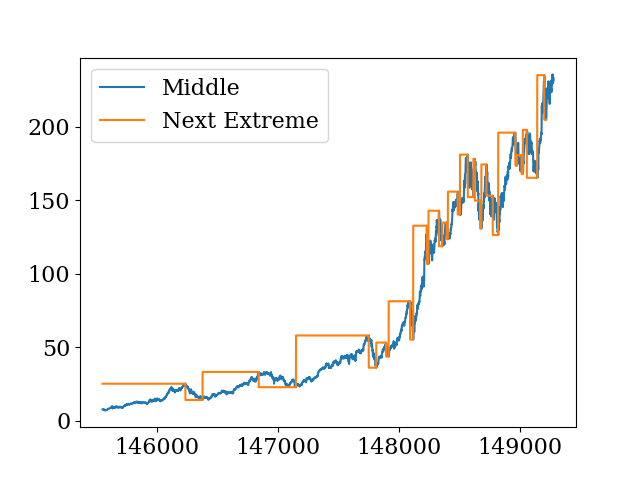

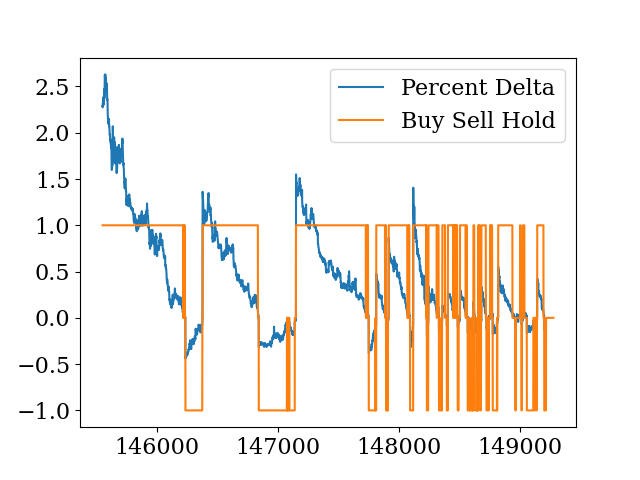

In [5]:
from notebooks.feature_extraction import get_individual_stock_df
from scipy.signal import find_peaks


def next_extreme_values(series):
    peak_indices, _ = find_peaks(
        series, threshold=0, distance=40, prominence=9, width=5
    )
    valley_indices, _ = find_peaks(
        -series, threshold=0, distance=40, prominence=9, width=5
    )
    extreme_indices = np.sort(np.concatenate((peak_indices, valley_indices)))
    next_extremes = np.full(len(series), np.nan)
    for i in range(len(series)):
        future_extremes = extreme_indices[extreme_indices > i]
        if future_extremes.size > 0:
            next_extremes[i] = series[future_extremes[0]]
    return next_extremes


def get_targets_df(
    stocks_df, target_stock_symbol, buy_threshold, sell_threshold
):
    df = get_individual_stock_df(stocks_df, target_stock_symbol)
    df["Middle"] = (df["High"] + df["Low"]) / 2
    df["Next Extreme"] = next_extreme_values(df["Middle"].to_numpy())

    delta = df["Next Extreme"].to_numpy() - df["Middle"].to_numpy()
    percent_delta = delta / df["Middle"].to_numpy()

    buy_indicators = (percent_delta > buy_threshold).astype(int)
    sell_indicators = (percent_delta < sell_threshold).astype(int)

    df["Percent Delta"] = percent_delta
    df["Buy Indicator"] = buy_indicators
    df["Sell Indicator"] = sell_indicators
    df["Buy Sell Hold"] = buy_indicators - sell_indicators

    df[["Middle", "Next Extreme"]].plot()
    df[["Percent Delta", "Buy Sell Hold"]].plot()
    return df


# Get the targets to predict
target_stock_symbol = "AAPL"
buy_threshold = 0.05
sell_threshold = -0.05
targets_df = get_targets_df(
    stocks_df, target_stock_symbol, buy_threshold, sell_threshold
)

start_idx = n_days_history + n_days_forward - 1
y_extreme_targets = targets_df["Next Extreme"].to_numpy()[start_idx:]
y_buy_sell_hold = targets_df["Buy Sell Hold"].to_numpy()[start_idx:]

y_extreme_train, y_extreme_test = make_train_test_split(y_extreme_targets)
y_buy_sell_hold_train, y_buy_sell_hold_test = make_train_test_split(
    y_buy_sell_hold
)

In [6]:
print("X array shape:", x_features.shape)
print("y targets shape:", y_extreme_targets.shape)
print("y targets shape:", y_buy_sell_hold.shape)
print("inference_dates shape:", inference_dates.shape)

X array shape: (3712, 40)
y targets shape: (3712,)
y targets shape: (3712,)
inference_dates shape: (3712,)


## Train a Model to Predict the Next Extreme

In [7]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from notebooks.error_metrics import compute_mae

### Random Forest

Random Forest Regressor Train Error:  6.404863468514846
Random Forest Regressor Test Error:  35.77578034034462


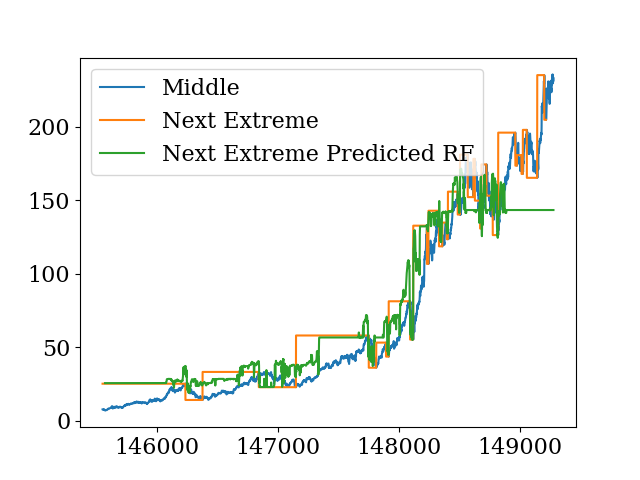

In [8]:
extreme_predictor_model_rf = RandomForestRegressor(
    max_depth=5, n_estimators=100, random_state=42
)

extreme_predictor_model_rf.fit(x_train, y_extreme_train)

y_extreme_train_hat_rf = extreme_predictor_model_rf.predict(x_train)
y_extreme_test_hat_rf = extreme_predictor_model_rf.predict(x_test)

extreme_predictor_rf_mae_train = compute_mae(
    y_extreme_train, y_extreme_train_hat_rf
)
extreme_predictor_rf_mae_test = compute_mae(
    y_extreme_test, y_extreme_test_hat_rf
)

n_nans = n_days_history + n_days_forward - 1
targets_df["Next Extreme Predicted RF"] = np.concatenate(
    (np.full(n_nans, np.nan), extreme_predictor_model_rf.predict(x_features))
)
targets_df[["Middle", "Next Extreme", "Next Extreme Predicted RF"]].plot()

print("Random Forest Regressor Train Error: ", extreme_predictor_rf_mae_train)
print("Random Forest Regressor Test Error: ", extreme_predictor_rf_mae_test)

In [9]:
np.any(np.isnan(y_extreme_test))

np.True_

MLP Regressor Train Error:  11.560626861653654
MLP Regressor Test Error:  26.24398129638787


/workspaces/fall-2024-class-08/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


<Axes: >

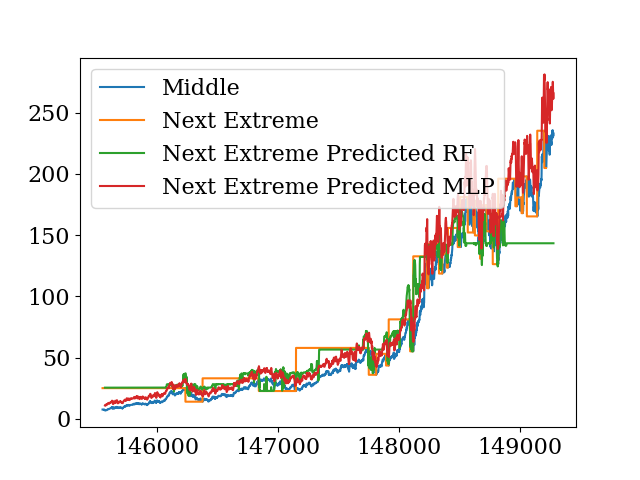

In [10]:
extreme_predictor_model_mlp = MLPRegressor(
    hidden_layer_sizes=(100, 100, 100),
    random_state=42,
    max_iter=1000,
    tol=0.00001,
    solver="adam",
    learning_rate="adaptive",
    learning_rate_init=0.00001,
    verbose=False,
)

extreme_predictor_model_mlp.fit(x_train, y_extreme_train)

y_extreme_train_hat_mlp = extreme_predictor_model_mlp.predict(x_train)
y_extreme_test_hat_mlp = extreme_predictor_model_mlp.predict(x_test)

extreme_predictor_mlp_mae_train = compute_mae(
    y_extreme_train, y_extreme_train_hat_mlp
)
extreme_predictor_mlp_mae_test = compute_mae(
    y_extreme_test, y_extreme_test_hat_mlp
)

print("MLP Regressor Train Error: ", extreme_predictor_mlp_mae_train)
print("MLP Regressor Test Error: ", extreme_predictor_mlp_mae_test)

n_nans = n_days_history + n_days_forward - 1
targets_df["Next Extreme Predicted MLP"] = np.concatenate(
    (np.full(n_nans, np.nan), extreme_predictor_model_mlp.predict(x_features))
)
targets_df[
    [
        "Middle",
        "Next Extreme",
        "Next Extreme Predicted RF",
        "Next Extreme Predicted MLP",
    ]
].plot()

In [11]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

In [12]:
# Initialize the Random Forest Classifier
classifier_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
classifier_rf.fit(x_train, y_buy_sell_hold_train)

y_buy_sell_hold_train_hat_rf = classifier_rf.predict(x_train)
y_buy_sell_hold_test_hat_rf = classifier_rf.predict(x_test)

train_accuracy_mlp = accuracy_score(
    y_buy_sell_hold_train, y_buy_sell_hold_train_hat_rf
)
print("Accuracy:", train_accuracy_mlp)
test_accuracy_mlp = accuracy_score(
    y_buy_sell_hold_test, y_buy_sell_hold_test_hat_rf
)
print("Accuracy:", test_accuracy_mlp)

print(
    "Classification Report:\n",
    classification_report(y_buy_sell_hold_test, y_buy_sell_hold_test_hat_rf),
)

n_nans = n_days_history + n_days_forward - 1
targets_df["Buy Sell Hold Predicted RF"] = np.concatenate(
    (np.full(n_nans, np.nan), classifier_rf.predict(x_features))
)

Accuracy: 1.0
Accuracy: 0.29475100942126514
Classification Report:
               precision    recall  f1-score   support

          -1       0.27      0.79      0.40       201
           0       0.21      0.06      0.09       271
           1       0.54      0.17      0.25       271

    accuracy                           0.29       743
   macro avg       0.34      0.34      0.25       743
weighted avg       0.35      0.29      0.23       743



In [13]:
classifier_mlp = MLPClassifier(
    hidden_layer_sizes=(100, 100, 100),
    random_state=42,
    max_iter=1000,
    tol=0.00001,
    solver="adam",
    learning_rate="adaptive",
    learning_rate_init=0.00001,
    verbose=False,
)

classifier_mlp.fit(x_train, y_buy_sell_hold_train)

y_buy_sell_hold_train_hat_mlp = classifier_mlp.predict(x_train)
y_buy_sell_hold_test_hat_mlp = classifier_mlp.predict(x_test)

train_accuracy_mlp = accuracy_score(
    y_buy_sell_hold_train, y_buy_sell_hold_train_hat_mlp
)
print("Accuracy:", train_accuracy_mlp)
test_accuracy_mlp = accuracy_score(
    y_buy_sell_hold_test, y_buy_sell_hold_test_hat_mlp
)
print("Accuracy:", test_accuracy_mlp)

print(
    "Classification Report:\n",
    classification_report(y_buy_sell_hold_test, y_buy_sell_hold_test_hat_mlp),
)

n_nans = n_days_history + n_days_forward - 1
targets_df["Buy Sell Hold Predicted MLP"] = np.concatenate(
    (np.full(n_nans, np.nan), classifier_rf.predict(x_features))
)

Accuracy: 0.7595149882115191
Accuracy: 0.36608344549125166
Classification Report:
               precision    recall  f1-score   support

          -1       0.26      0.16      0.20       201
           0       0.00      0.00      0.00       271
           1       0.39      0.89      0.54       271

    accuracy                           0.37       743
   macro avg       0.22      0.35      0.25       743
weighted avg       0.21      0.37      0.25       743

